In [175]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

import lightgbm as lg

from collections import OrderedDict    # For recording the model specification 

import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion
from statsmodels.stats.descriptivestats import describe

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit, MultinomialLogit
import lightgbm as lgb

import pickle
import json

In [2]:
df = pd.read_csv("data/data_2022v2.csv", index_col=0)
df["classement"] = df["classement"].replace(['DA', 'NP', '0', 'A ', 'G ', 'D4', 'D3', 'R8', 'D5', 'D2', 'D8', 'D7', 'H8', 'D1', 'D6',
       'D9', 'G4', 'T ', 'G3', 'D ', 'G7'], 10).astype(int)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (123,125,126) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,deferre,...,medianPerf,modePerf,recordAbs,gain,placeCorde,ecurie,avisEntraineur,tauxReclamation,commentaireApresCourse_texte,commentaireApresCourse_source
0,IROCKO STRYCK,1,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie LES TILLEULS,P. TERRY,DEFERRE_POSTERIEURS,...,3.0,0,0.527465,24490,NaN,NaN,NaN,NaN,NaN,NaN
1,I AM EAGLE,2,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie TENACIOUS SAUVIGNEY,F. MARTY,DEFERRE_POSTERIEURS,...,4.0,4,0.316479,28940,NaN,NaN,NaN,NaN,NaN,NaN
2,IT'S VERY GOOD,3,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mathieu VERDEZ,B. COURBOT,NaN,...,6.0,0,-0.105493,29980,NaN,NaN,NaN,NaN,NaN,NaN
3,IDEAL DE MOUTIERS,4,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,L.B. MARTIN,L.B. MARTIN,DEFERRE_POSTERIEURS,...,4.0,2,1.265916,30440,NaN,NaN,NaN,NaN,NaN,NaN
4,IRRATI DUEM,5,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie DUEM,J. CHAVATTE,NaN,...,1.5,0,0.105493,31470,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
feat = df.loc[:]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsCarriere"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat["publicProbaOfWinning"] = 1 / feat["dernierRapportDirect_rapport"]

feat.fillna(0,inplace=True)

feat.replace([np.inf, -np.inf], 0, inplace=True)

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)

feat["newDist"] = feat["newDist"].astype(int)

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

feat = feat.assign(num=nindex)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

feat["classement"].replace(0, 10, inplace=True)

In [189]:
# feat.set_index(["id", df.groupby("id").cumcount()]).reindex(test_index, fill_value=0).reset_index(level=1, drop=True).reset_index()

In [190]:
multiindex = [[],[]]

for i in feat.id.unique():
    for j in range(1,22):
        multiindex[0].append(i)
        multiindex[1].append(j)

In [191]:
# feat = feat.set_index(["id", df.groupby("id").cumcount()])
# test_index = pd.MultiIndex.from_arrays(multiindex, names=["id", "num"])
# feat = feat.reindex(test_index, fill_value=0).reset_index(level=1, drop=True).reset_index()

# nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

# feat = feat.assign(num=nindex)
# feat[["id", "num","nom"]].head(25)

In [192]:
n_explo = 2

nfeat = feat.iloc[:18*(len(feat.groupby("id"))//2)].copy()

train = nfeat.copy()
print(len(train.groupby("chid")))
for i in range(2,n_explo+2):
    cfeat = nfeat.copy()

    cfeat["win"] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num"])] = 0
    cfeat.loc[cfeat["classement"] == i, "win"] = 1
    cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
    train = pd.concat([train, cfeat])
    print(len(train.groupby("chid")))
train = train.sort_values(by=["id", "chid", "num"])

784
1568
2352


In [193]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * (len(feat.groupby("id")) // 2):]

In [172]:
train[["id", "nom", "win", "classement"]].head(30)

,id,nom,win,classement
0,2022010275001,SUNDAY SONATA,0,10
1,2022010275001,XANTHIS DELICIOUS,0,9
2,2022010275001,FLORE MERITE,0,10
3,2022010275001,ADI GALLIA,0,10
4,2022010275001,FOLIE DE HOUELLE,0,10
5,2022010275001,ZANZIBAR WISE AS,0,2
6,2022010275001,FABULEUSE FLIGNY,0,10
7,2022010275001,FLORA VENESI,0,3
8,2022010275001,FAVORITE,0,8
9,2022010275001,ZANTE BREED,1,1


In [195]:
set(list(feat)) - set(features)

{'age',
 'allure',
 'available',
 'avisEntraineur',
 'avisTrainer',
 'chid',
 'classement',
 'commentaireApresCourse_source',
 'commentaireApresCourse_texte',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'dist',
 'driver',
 'driverChange',
 'e

In [205]:
# model = pickle.load(open('models/model_rapport.pickle', 'rb'))

In [28]:
# model = MultinomialLogit()
model = pickle.load(open('models/cl_v1.pickle', 'rb'))

In [158]:
features = ['acceleration_500m',
 'nbVictoiresCouple',
 'nbCourseCouple',
 'rentree',
 'last_race_dist',
 'tpsLastRace',
 'timeSinceRecord',
 'minReduction',
 'medianReduction',
 'meanReduction',
 'changementCategorie',
 'distToPreferedDist',
 'prefered_dist',
 'jockeyHabitude',
 'nbDiscalifieMusic',
 'nbVictoireMusic',
 'nbPlaceMusic',
 'fer',
 'gainsParticipant_gainsCarriere']
features_bac = ["fer","maxReduction_z","num","meanReduction_z","medianPerf_z","medianReduction_z","nbVictoiresTrainer_z","modePerf_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs_z","nbDiscalifieMusic_z","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"u"}

In [173]:
train["chid"].head()

0    2022010275001_1
1    2022010275001_1
2    2022010275001_1
3    2022010275001_1
4    2022010275001_1
Name: chid, dtype: object

In [342]:
ranker = lg.LGBMRanker(boosting_type="dart",n_estimators=1000,num_leaves=100)
groups = train.groupby('chid').size().to_frame('size')['size'].to_numpy()
ranker.fit(train[features], y=train["classement"], group =groups )

LGBMRanker(boosting_type='dart', n_estimators=1000, num_leaves=100)

In [368]:
pickle.dump(ranker, open("models/rankerv1.pickle", "wb"))

In [345]:
rank_pred = ranker.predict(train[features])
train["rank_pred"] = rank_pred
# train['rank_pred'] = train.groupby("chid")["rank_pred"].rank("dense",ascending=True).astype(int)
# train['rank_pred'] = train.groupby("chid")["rank_pred"].rank("first").astype(int)

In [344]:
sum(train[train["win"] == 1]["rank_pred"] == 1) / len(train[train["win"] == 1])

0.3270788912579957

In [159]:
# model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"],alts=train["num"],avail=train["available"],maxiter=10000,tol_opts={"gtol": 1e-10})
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 6
    Function evaluations: 7
Estimation time= 0.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
acceleration_500m       0.0088066     0.0016533     5.3267267      5.89e-07 ***
nbVictoiresCouple       0.1643159     0.0254908     6.4460772      8.79e-10 ***
nbCourseCouple         -0.1254459     0.0302466    -4.1474323       0.00015 ***
rentree                -0.1511546     0.0793448    -1.9050342          0.13    
last_race_dist         -0.0001157     0.0000798    -1.4486052         0.279    
tpsLastRace            -0.1538196     0.0340690    -4.5149459      3.09e-05 ***
timeSinceRecord        -0.0774026     0.0221274    -3.4980489       0.00178 ** 
minReduction           -0.0651870     0.0268797    -2.

In [346]:
choice_estimate, proba_estimate = model.predict(X=train[features], varnames=features, ids=train["chid"], alts=train["num"],avail=train["available"],return_proba=True)
train["probaModel"] = proba_estimate.flatten()
train["probaModel"].replace(-np.inf,0, inplace=True)
train["probaModel"].fillna(0, inplace=True)

In [251]:
null_model = MultinomialLogit()
null_model.fit(X=train[["publicProbaOfWinning"]], y=train["win"], varnames=["publicProbaOfWinning"], ids=train["chid"],alts=train["num"],avail=train["available"])
null_model.summary()
null_choice, null_proba = null_model.predict(X=test[["publicProbaOfWinning"]], varnames=["publicProbaOfWinning"], ids=test["id"], alts=test["num"], return_proba=True)

accu = np.sum(winners == null_choice)/len(null_choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 5
    Function evaluations: 6
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     5.7413131     0.1627448    35.2780093     1.05e-217 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -5202.404
AIC= 10406.808
BIC= 10412.568
Win%: 33.29%, nbet: 784


In [347]:
second_model = MixedLogit()
# second_model = pickle.load(open('models/cl_v2.pickle', 'rb'))
second_model.fit(X=train[["probaModel", "publicProbaOfWinning","rank_pred"]],y=train["win"],varnames=["probaModel", "publicProbaOfWinning","rank_pred"], ids=train["chid"],alts=train["num"],avail=train["available"], randvars={"rank_pred":"n"})
second_model.summary()

GPU processing enabled.
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 5
    Function evaluations: 13
Estimation time= 1.2 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
probaModel             -1.8853938     0.4205265    -4.4834120      3.58e-05 ***
publicProbaOfWinnin     4.3976482     0.2161853    20.3420285       1.3e-83 ***
rank_pred              -1.3126277     0.0554676   -23.6647543     6.39e-110 ***
sd.rank_pred           -0.0000075    33.6612650    -0.0000002         0.798    
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -3688.076
AIC= 7384.152
BIC= 7407.192


In [266]:
pickle.dump(second_model, open("models/cl_v2.pickle", "wb"))

In [348]:
choice_model, proba_model = model.predict(X=test[features], varnames=features, ids=test["id"], alts=test["num"],avail=test["available"],return_proba=True)
test["probaModel"] = proba_model.flatten()
test["probaModel"].replace(-np.inf,0, inplace=True)
test["probaModel"].fillna(0, inplace=True)

rank_pred = ranker.predict(test[features])
test["rank_pred"] = rank_pred
# test['rank_pred'] = test.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("id")["rank_pred"].rank("first").astype(int)

In [353]:
choice, proba = second_model.predict(X=test[["probaModel", "publicProbaOfWinning","rank_pred"]],varnames=["probaModel", "publicProbaOfWinning","rank_pred"], ids=test["id"],alts=test["num"],avail=test["available"], return_proba=True)

GPU processing enabled.


In [354]:
sum(choice_model == choice) / len(choice_model)

0.3737244897959184

In [355]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return p - (1-p)/(b-1)

def expe(p,b):
    e = p*(b+1)
    m_e = np.argmax( e )
    return m_e, e[m_e]

In [356]:
test["proba"] = proba.flatten()

In [357]:
nb_chevaux = []
proba_moy_theo = []
proba_moy = []
rapport_moyen = []
classe = [0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,1.]
inter = []
for i,j in zip(classe, classe[1:]):
    inter.append(f"{i} à {j}")
    echantillon = proba.flatten()[(i < proba.flatten()) & (proba.flatten() <= j)]
    
    rapport = test[(i < test["proba"] ) & (test["proba"] <=j )]["dernierRapportDirect_rapport"].to_numpy()
    rapport_moyen.append(np.mean(rapport))
    nb_chevaux.append( len(echantillon ))
    proba_moy.append( np.mean(echantillon) )
    proba_moy_theo.append(np.mean([i,j]))
rapport_moy_theo = 1/np.array(proba_moy_theo)

In [358]:
pd.DataFrame({"PROBA": inter, "Proba moyenne théorique": proba_moy_theo, "Rapport théorique": rapport_moy_theo, "Proba moyenne": proba_moy,"Rapport moyen": rapport_moyen, "NB Chevaux": nb_chevaux})

,PROBA,Proba moyenne théorique,Rapport théorique,Proba moyenne,Rapport moyen,NB Chevaux
0,0 à 0.01,0.0050,200.000000,0.004347,56.623388,2544
1,0.01 à 0.025,0.0175,57.142857,0.016574,36.236911,1910
2,0.025 à 0.05,0.0375,26.666667,0.036268,29.105093,1669
3,0.05 à 0.1,0.0750,13.333333,0.070792,21.416514,1532
4,0.1 à 0.15,0.1250,8.000000,0.121085,16.010759,725
5,0.15 à 0.2,0.1750,5.714286,0.172471,12.843309,411
6,0.2 à 0.25,0.2250,4.444444,0.223357,9.848043,281
7,0.25 à 0.3,0.2750,3.636364,0.273338,9.746196,184
8,0.3 à 0.4,0.3500,2.857143,0.343533,7.467073,246
9,0.4 à 1.0,0.7000,1.428571,0.588718,4.775749,367


In [359]:
accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 24.23%, nbet: 784


In [68]:
with open("data/rapport.json", "r") as f:
    rapports = json.load(f)

In [277]:
feat.iloc[0]

id                        2022010275001
nom                       SUNDAY SONATA
numPmu                                1
age                                   7
sexe                           FEMELLES
                             ...       
winPrace                        2.67315
publicProbaOfWinning           0.010753
win                                   0
available                             1
chid                    2022010275001_1
Name: 0, Length: 132, dtype: object

In [278]:
test.loc[test["id"] == won_id[-1]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
28044,2022112450087,1,R4C7,7,2022-11-24,8.9
28045,2022112450087,2,R4C7,10,2022-11-24,71.0
28046,2022112450087,3,R4C7,3,2022-11-24,8.5
28047,2022112450087,4,R4C7,10,2022-11-24,22.0
28048,2022112450087,5,R4C7,8,2022-11-24,21.0
28049,2022112450087,6,R4C7,2,2022-11-24,7.5
28050,2022112450087,7,R4C7,6,2022-11-24,13.0
28051,2022112450087,8,R4C7,1,2022-11-24,2.6
28052,2022112450087,9,R4C7,4,2022-11-24,44.0
28053,2022112450087,10,R4C7,10,2022-11-24,9.8


       mean   max  min  median
0  3.428571  20.1  1.1     2.3
0.2975708502024291% de win
110.00000000000003 sur 494 paris


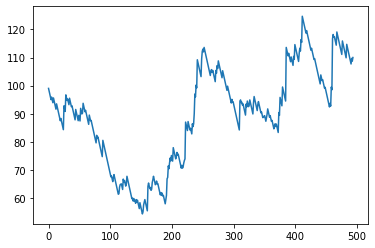

In [367]:
place = []
courses_list = test["id"].unique()

rapport_won = []
evo = []
money = 100
wins = 0

won_id = []

for i in range(len(choice)):
    choice_in_df = test[(test["id"] == courses_list[i]) & (test["num"] == choice[i])].iloc[0]
    sorted_proba = np.argsort(proba[i])
    
    
#     proba_jumele = 2*proba[i, sorted_proba[-1]] * (proba[i, sorted_proba[-2]]**(0.76)) *(proba[i, sorted_proba[-3]]**(0.76))/ np.sum(proba[i]**(0.76))
#     proba_jumele += 2*proba[i, sorted_proba[-3]] * (proba[i, sorted_proba[-1]]**(0.76))*(proba[i, sorted_proba[-2]]**(0.76)) / np.sum(proba[i]**(0.76))
# #     proba_jumele += proba[i, sorted_proba[-2]] * (proba[i, sorted_proba[-1]]**(0.76))*(proba[i, sorted_proba[-3]]**(0.76)) / np.sum(proba[i]**(0.76))
# #     print(proba_jumele)
    
    bet_size = 1
    if str(choice_in_df.id) in rapports:
        if "E_DEUX_SUR_QUATRE" in rapports[str(choice_in_df.id)]:
            odd = rapports[str(choice_in_df.id)]["E_DEUX_SUR_QUATRE"]["rapports"]
            for j in odd:
#                 print(j["combinaison"], sorted_proba[-1] + 1)
#                 if True:
                if all([x in [sorted_proba[-1] + 1, sorted_proba[-2] + 1] for x in j["combinaison"]]):
#                     print((j["dividendePourUnEuro"] / 100), j["combinaison"])

                    money += bet_size * j["dividendePourUnEuro"] / 100
                    rapport_won.append(j["dividendePourUnEuro"] / 100)
                    won_id.append(courses_list[i])
                    wins+=1


            money -= 1
            evo.append(money)

rapport_won = np.array(rapport_won)
print(describe(rapport_won, stats=["max", "min", "mean", "median"]).T)
print(f"{wins/len(evo)}% de win")
print(f"{money} sur {len(evo)} paris")
evo = np.array(evo)
plt.plot(evo)

In [365]:
rapports["2022112450087"]

{'E_SIMPLE_GAGNANT': {'typePari': 'E_SIMPLE_GAGNANT',
  'miseBase': 100,
  'rembourse': False,
  'rapports': [{'libelle': 'e-Simple Gagnant',
    'dividende': 290,
    'dividendePourUnEuro': 290,
    'combinaison': [8],
    'nombreGagnants': 4454.6,
    'dividendePourUneMiseDeBase': 290,
    'dividendeUnite': 'PourUnEuro'}],
  'audience': 'NATIONAL',
  'famillePari': 'Simple',
  'dividendeUnite': 'PourUnEuro'},
 'E_SIMPLE_PLACE': {'typePari': 'E_SIMPLE_PLACE',
  'miseBase': 100,
  'rembourse': False,
  'rapports': [{'libelle': 'e-Simple Placé',
    'dividende': 170,
    'dividendePourUnEuro': 170,
    'combinaison': [8],
    'nombreGagnants': 2508.09,
    'dividendePourUneMiseDeBase': 170,
    'dividendeUnite': 'PourUnEuro'},
   {'libelle': 'e-Simple Placé',
    'dividende': 210,
    'dividendePourUnEuro': 210,
    'combinaison': [6],
    'nombreGagnants': 1587.9,
    'dividendePourUneMiseDeBase': 210,
    'dividendeUnite': 'PourUnEuro'},
   {'libelle': 'e-Simple Placé',
    'dividende

In [327]:
rapport_won

array([ 14.6,   8.3,   5.5,  31.1,  18.7,  30. ,   4.5,   6.6,   9.6,
         2.5,   4. ,  13.6,  11.1,  10.2,  12.6,  12.9,   6. ,   9.7,
         6.3,  18.4,  10.8,   8.6,  23.6,   4. ,  47.2,   7.4,   8.4,
         4.1,  22.5,  84.6,   9.7, 109.5])

In [281]:
test.loc[test["id"] == race_id[0]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
13644,2022073175025,1,R3C5,1,2022-07-31,4.7
13645,2022073175025,2,R3C5,10,2022-07-31,8.5
13646,2022073175025,3,R3C5,2,2022-07-31,25.0
13647,2022073175025,4,R3C5,5,2022-07-31,5.8
13648,2022073175025,5,R3C5,2,2022-07-31,5.8
13649,2022073175025,6,R3C5,7,2022-07-31,18.0
13650,2022073175025,7,R3C5,4,2022-07-31,3.2
13651,2022073175025,8,R3C5,6,2022-07-31,20.0
13652,2022073175025,9,R3C5,8,2022-07-31,91.0
13653,2022073175025,10,R3C5,10,2022-07-31,20.0


       mean   max   min  median
0  4.315385  19.8  1.43     3.3
Win%: 0.2311111111111111, nwin: 156,nbet: 675
Gain de -1€, gain moyen de 0.08%


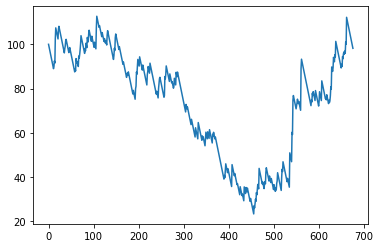

In [363]:
win = 0
tot = 0
odds_winned = []
expe_won = []

money = 100
evo = [money]

lstreak = 0

sorted_proba = np.argsort(proba)

race_id = []

bet = []

for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
#     place_best = sorted_proba[i, -3:]
    
#     best_place,Er = expe(proba[i], odds[i])
#     print(best_place,Er, place_best[best_place])
#     best_expe = place_best[best_place]
    
    er = proba[i, :] * odds[i, :]
    er_sorted = np.argsort(er)
    er_pos = er_sorted[ np.sort(er) > 0  ]
    
    prob = proba[i, er_pos]
    
    filtre = er_pos[prob > 0.1]
    
    advantage = er - 1
    
    p = proba[i, choice[i] - 1]
    
    sorted_proba = np.argsort(proba[i])
    advantage = p - proba[i, sorted_proba[-2]]
    
    choice_expe = proba[i, choice[i] - 1] * odds[i][choice[i] - 1]
#     print(proba[i, choice[i] - 1] * odds[i][choice[i] - 1] - (1-proba[i, choice[i] - 1]))
#     print(advantage,p ,proba[i, sorted_proba[-1]],proba[i, sorted_proba[-2]])
    if choice_expe>1:
        wagger = kelly(proba[i][choice[i] - 1],odds[i][ choice[i] - 1])
        bet_value = min(wagger*money/3, 0.05*money)
        bet_value = 1
#         print(wagger, choice_expe, proba[i][choice[i] - 1],odds[i][ choice[i] - 1])
        if choice[i] == winners[i]:
            race_id.append( test["id"].unique()[i] )
            win += 1
#             print(f"Win le {winners[i]}|{choice[i]} a gagné  avec une cote de {odds[i][winners[i] - 1]}")
            money += 1.1*odds[i][ winners[i] - 1] * bet_value
            odds_winned.append(1.1*odds[i][winners[i] - 1])
            expe_won.append(choice_expe)
            lstreak = 0
        else:
            lstreak += 1
        money -= bet_value
        bet.append(bet_value)
        evo.append(money)
        tot+=1
        
print(describe(odds_winned, stats=["max", "min", "mean", "median"]).T)
# print(describe(expe_won, stats=["max", "min", "mean", "median"]).T)
print(f"Win%: {win/tot}, nwin: {win},nbet: {tot}")
print(f"Gain de {int(money-100)}€, gain moyen de {round(np.mean((np.array(evo[1:]) - np.array(evo[:-1]))/ np.array(evo[:-1]))*100,2)}%")
plt.plot(evo)
# plt.yscale("log")

In [59]:
bet

[1.0,
 1.2,
 1.0,
 1.2,
 1.44,
 1.0,
 1.2,
 1.44,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 1.0,
 1.0,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.2,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 1.0,
 1.0,
 1.0,
 1.0,
 1.2,
 1.0,
 1.2,
 1.0,
 1.2,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 2.4883199999999994,
 2.9859839999999993,
 1.0,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.0,
 1.2,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.2,
 1.44,
 1.0,
 1.2,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.2,
 1.0,
 1.2,
 1.0,
 1.0,
 1.2,
 1.0,
 1.2,
 1.44,
 1.0,
 1.2,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 2.4883199999999994,
 1.0,
 1.2,
 1.0,
 1.0,
 1.2,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 2.0736,
 2.4883199999999994,
 1.0,
 1.2,
 1.0,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.2,
 1.44,
 1.7279999999999998,
 1.0,
 1.0,
 1.2,


In [150]:
np.mean((np.array(evo[1:]) - np.array(evo[:-1]))/ np.array(evo[:-1]))

0.0009021730021085995

In [119]:
test[["num", "nom","numCoursePMU", "dernierRapportDirect_rapport"]]

,num,nom,numCoursePMU,dernierRapportDirect_rapport
115561,2,GLORIA D'AVE,R11C2,18.0
115562,3,GOODMORNING CHARLY,R11C2,5.5
115563,4,GATINKA,R11C2,25.0
115564,5,GALIA SOTHO,R11C2,3.3
115565,6,GROVE CITY,R11C2,13.0
...,...,...,...,...
130446,12,HARLEY GEMA,R1C9,3.8
130447,13,HAUTE COUTURE,R1C9,13.0
130448,14,HORCHATA,R1C9,8.6
130449,15,HELIA DU GARABIN,R1C9,8.2


# PyLogit

In [57]:
# Create the model's specification dictionary and variable names dictionary
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.




# features_bu = ["available","trainerIsDriver","txReussiteDriver_z","fer","nbArrivé_z","nb3emeTandem_z","nb3emeDriver_z","nb3emeCouple_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","winPrace","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]

example_specification = OrderedDict()
example_names = OrderedDict()

for col in features:
    example_specification[col] = [list(range(1,19))]
    example_names[col] = [col]

In [58]:
train[features].apply(pd.to_numeric)

,num,dist,lifepercwin,winPrace,formeVictoire,formePlace,nbArriveMusic,lastPerf,meanPerf,medianPerf,...,changementCategorie,distToPreferedDist,prefered_dist,jockeyHabitude,nbDiscalifieMusic,nbVictoireMusic,nbPlaceMusic,fer,firstTimeFer,gainsParticipant_gainsCarriere
0,1,2700,0.409091,4.504293,0,0,-1.6,-0.727273,-1.196854,-0.666667,...,0,-0.854795,0.723898,1,2.000000,-1.0,-0.8,3,0,-4.003816
1,2,2700,0.409091,1.604153,1,1,-0.6,0.545455,-0.341958,-0.333333,...,0,2.432877,-2.060325,1,-1.333333,2.0,0.0,1,1,-1.425914
2,3,2700,0.000000,0.000000,0,1,0.0,0.000000,0.132984,0.000000,...,0,0.000000,0.000000,0,0.666667,-1.0,0.4,3,0,-0.589825
3,4,2700,0.461538,0.743243,0,0,-1.0,-0.727273,0.940386,1.000000,...,0,2.410959,-2.041763,0,0.000000,-1.0,-0.8,3,0,-0.585586
4,5,2700,0.000000,-0.735404,0,0,-0.4,0.909091,0.390810,0.666667,...,0,0.252055,-0.213457,0,2.000000,-1.0,0.0,3,0,-0.430843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,14,2825,0.188889,0.000000,0,0,-1.0,0.516129,1.206024,1.076923,...,1,-0.359932,0.359932,0,-0.250000,-1.0,-1.0,0,0,0.000000
19310,15,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19311,16,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19312,17,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000


In [59]:
train["chid"].dtypes

dtype('int64')

In [60]:
# The 'alt_id_column' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
alt_id_column = "num"

# The "obs_id_column" is a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. This column denotes each individual choice
# situation.
obs_id_column = "chid"

# The "choice_column" records the name of the column that denotes whether or not each
# individual chose the alternative on a given row.
choice_column = "win"

In [78]:
# Provide the module with the needed input arguments to create
# an instance of the MNL model class


example = pl.create_choice_model(data=train,
                                        alt_id_col=alt_id_column,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=example_specification,
                                        model_type="MNL",
                                        names=example_names)

# Create the initial values for estimation.
# Note that we need one value for each beta
# coefficient and for each of the standard deviations
# that will now be estimated.

example.fit_mle(init_vals=np.zeros(len(features)))
example.get_statsmodels_summary()

Log-likelihood at zero: -9,263.6415
Initial Log-likelihood: -9,263.6415


C:\Users\raves\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.81 seconds.
Final log-likelihood: -7,948.5208


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                         win   No. Observations:                3,205
Model:             Multinomial Logit Model   Df Residuals:                    3,169
Method:                                MLE   Df Model:                           36
Date:                     Thu, 24 Nov 2022   Pseudo R-squ.:                   0.142
Time:                             13:42:32   Pseudo R-bar-squ.:               0.138
AIC:                            15,969.042   Log-Likelihood:             -7,948.521
BIC:                            16,187.650   LL-Null:                    -9,263.641
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
num                               -0.0018      0.005     -0.338      0.735      -0.012       0.009
dist                               0.7106      0.003    238.108      0.000       0.705       0.716
lifepercwin                    -7.531e-05      0.004     -0.021      0.983      -0.007       0.007
winPrace                          4.4e-05      0.003      0.015      0.988      -0.006       0.006
formeVictoire                   8.061e-05      0.087      0.001      0.999      -0.171       0.171
formePlace                         0.0002      0.059      0.004      0.997      -0.115       0.115
nbArriveMusic                      0.0001      0.030      0.004      0.997      -0.058       0.058
lastPerf                        1.249e-05      0.026      0.000      1.000      -0.050       0.050
meanPerf                          -0.0002      0.036     -0.007      0.995      -0.071       0.070
medianPerf                        -0.0002      0.039     -0.006      0.996      -0.077       0.076
modePerf                           0.0001      0.013      0.011      0.991      -0.025       0.025
recordAbs                         -0.0001      0.024     -0.004      0.997      -0.047       0.046
txReussiteCouple                   0.0003      0.021      0.015      0.988      -0.041       0.042
nb3emeCouple                       0.0002      0.018      0.009      0.993      -0.036       0.036
nb2emeCouple                       0.0002      0.019      0.011      0.991      -0.037       0.038
nbVictoiresCouple                  0.0003      0.021      0.015      0.988      -0.040       0.041
nbCourseCouple                  8.486e-05      0.021      0.004      0.997      -0.041       0.041
rentree                         5.163e-06      0.051      0.000      1.000      -0.101       0.101
last_race_dist                     0.7178   7.13e-05   1.01e+04      0.000       0.718       0.718
tpsLastRace                       -0.0002      0.005     -0.032      0.974      -0.011       0.011
timeSinceRecord                 -9.24e-05      0.016     -0.006      0.996      -0.032       0.032
minReduction                      -0.0001      0.014     -0.009      0.993      -0.028       0.028
maxReduction                   -2.972e-05      0.017     -0.002      0.999      -0.034       0.034
medianReduction                   -0.0001      0.022     -0.006      0.995      -0.043       0.043
meanReduction                     -0.0001      0.034     -0.004      0.997      -0.067       0.067
newDist                            0.0001      0.041      0.003      0.997      -0.081       0.081
changementCategorie                0.0002      0.041      0.004      0.997      -0.081       0.081
distToPreferedDist              1.308e-06      0.021   6.27e-05      1.000      -0.041       0.041
prefered_dist                   4.412e-05      0.022      0.002      0.998      -0.043       0.043
jockeyHabitude              

In [75]:
preds = example.predict(test).reshape(-1,18)
preds_course = np.argmax(preds, axis=1) + 1
acu = sum(test.loc[test["win"] == 1]["num"] == preds_course) / len(preds_course)
print(acu)

0.0625


In [77]:
preds[0]

array([1.00000000e-001, 1.00000000e-001, 1.00000000e-001, 1.00000000e-001,
       1.00000000e-001, 1.00000000e-001, 1.00000000e-001, 1.00000000e-001,
       1.00000000e-001, 1.00000000e-001, 9.66331526e-306, 9.64565933e-306,
       9.62803566e-306, 9.61044419e-306, 9.59288487e-306, 9.57535762e-306,
       9.55786240e-306, 9.54039915e-306])

In [13]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

In [71]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

In [106]:
winners = test.loc[test["win"] == 1]["num"].to_numpy()
odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

sorted_preds = np.argsort(preds)

best_p = 0
best_er = 0

best_cap = 0



for p_tresh in np.linspace(0,0.2,40):
    for er_tresh in np.linspace(0,1.5,40):
        win = 0
        tot = 0
    #     odds_winned = []

        cap = 100
    #     evo = [cap]


        for i in range(len(preds)):
            preds1 = sorted_preds[i][-1]
            preds2 = sorted_preds[i][-2]
            cheval,Er = expe(preds[i], odds[i])
            if odds[i][cheval] > 0 and Er > er_tresh and preds[i][cheval] > p_tresh:
                wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
                if winners[i] == cheval + 1:
                    win += 1
                    cap += wagger * odds[i][cheval]
    #                 odds_winned.append(odds[i][cheval])
                cap -= wagger
    #             evo.append(cap)
                tot+=1

        if cap > best_cap:
            best_cap = cap
            best_p = p_tresh
            best_er = er_tresh
print(f"Best cap: {best_cap} for params: {best_p=}, {best_er=}")

Best cap: 460.79357800673836 for params: best_p=0.015384615384615385, best_er=0.9230769230769231


                 0
mean     21.361538
max     173.000000
min       4.400000
median    8.000000
Win%: 0.13829787234042554, nbet: 94


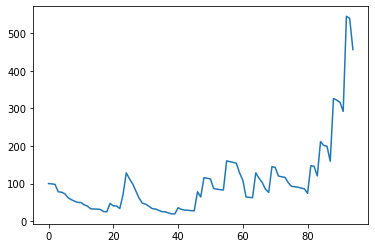

In [108]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

cap = 100
evo = [cap]


winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

for i in range(len(preds)):
    preds1 = sorted_preds[i][-1]
    preds2 = sorted_preds[i][-2]
    cheval,Er = expe(preds[i], odds[i])
    if odds[i][cheval] > 0 and Er > 0.92 and preds[i][cheval] > 0.015:
        wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
        if winners[i] == cheval + 1:
            win += 1
            cap += wagger * odds[i][cheval]
            odds_winned.append(odds[i][cheval])
        cap -= wagger
        evo.append(cap)
        tot+=1
print(describe(odds_winned, stats=["max", "min", "mean", "median"]))
print(f"Win%: {win/tot}, nbet: {tot}")
plt.plot(evo)

In [89]:
mean_odds = np.mean(odds_winned)
median_odds = np.median(odds_winned)
print(mean_odds, median_odds, np.max(odds_winned), np.min(odds_winned))

5.328688524590164 4.8 15.0 1.4


In [99]:
test

,id,num,nom,numCoursePMU,classement,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z,lifepercwin,winPrace,newDist,win,available
15948,2021072250083,1,HIPPO DE BEAUM,R6C3,10,2021-07-22,783.571429,781.0,822,765,...,-1.681135,-0.714631,-0.735320,-0.873203,-2.227441,0.000000,19583.333333,0,0,1
15949,2021072250083,2,HACH DES CAPELLES,R6C3,8,2021-07-22,801.000000,802.0,805,794,...,-0.898975,-0.697110,-0.718105,-0.873203,-0.928100,0.100000,99700.000000,1,0,1
15950,2021072250083,3,HOCHE,R6C3,1,2021-07-22,777.000000,777.5,784,769,...,0.665343,1.475570,1.055025,0.948539,0.725606,0.000000,70000.000000,0,1,1
15951,2021072250083,4,HADOL DU CHATELET,R6C3,10,2021-07-22,783.142857,790.0,795,761,...,1.660819,0.249057,0.504149,1.164271,0.371240,0.066667,48866.666667,1,0,1
15952,2021072250083,5,HAUGAIN,R6C3,6,2021-07-22,781.500000,784.5,798,759,...,-0.970081,-0.714631,-0.735320,-0.801293,-1.046222,0.100000,116700.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31891,2021123175009,14,HORCHATA,R1C9,7,2021-12-31,766.727273,765.0,807,733,...,1.153314,-0.046198,-0.047263,0.186222,-0.025928,0.142857,133761.904762,1,0,1
31892,2021123175009,15,HELIA DU GARABIN,R1C9,8,2021-12-31,769.500000,766.5,805,741,...,-0.314991,-0.847823,-0.962680,-1.116216,-0.440775,0.307692,210000.000000,1,0,1
31893,2021123175009,16,HELEN DES OUBEAUX,R1C9,4,2021-12-31,774.500000,766.5,811,750,...,-0.672146,0.620089,1.040624,0.560896,0.527201,0.000000,50875.000000,1,0,1
31894,2021123175009,17,0,0,10,0,0.000000,0.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0


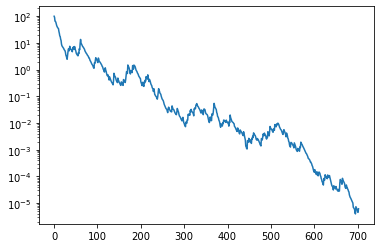

In [90]:
plt.plot(evo)
plt.yscale("log")

In [3]:
import pickle
example_mixed = pickle.load(open("mixedlogit1.pkl", "rb"))

# PyLogit

In [8]:
# NOTE: - Specification and variable names must be ordered dictionaries.
#       - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         of integers or or lists of lists of integers. Within a list, 
#         or within the inner-most list, the integers should be the 
#         alternative ID's of the alternative whose utility specification 
#         the explanatory variable is entering. Lists of lists denote 
#         alternatives that will share a common coefficient for the variable
#         in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()


for f in features:
    print(f)

basic_specification["intercept"] = [1, 2]
basic_names["intercept"] = ['ASC Train',
                            'ASC Swissmetro']

basic_specification["travel_time_hrs"] = [[1, 2,], 3]
basic_names["travel_time_hrs"] = ['Travel Time, units:hrs (Train and Swissmetro)',
                                  'Travel Time, units:hrs (Car)']

basic_specification["travel_cost_hundreth"] = [1, 2, 3]
basic_names["travel_cost_hundreth"] = ['Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)',
                                       'Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)',
                                       'Travel Cost, units: 0.01 CHF (Car)']

basic_specification["headway_hrs"] = [1, 2]
basic_names["headway_hrs"] = ["Headway, units:hrs, (Train)",
                              "Headway, units:hrs, (Swissmetro)"]

basic_specification["seat_configuration"] = [2]
basic_names["seat_configuration"] = ['Airline Seat Configuration, base=No (Swissmetro)']

basic_specification["train_survey"] = [[1, 2]]
basic_names["train_survey"] = ["Surveyed on a Train, base=No, (Train and Swissmetro)"]

basic_specification["regular_class"] = [1]
basic_names["regular_class"] = ["First Class == False, (Swissmetro)"]

basic_specification["single_luggage_piece"] = [3]
basic_names["single_luggage_piece"] = ["Number of Luggage Pieces == 1, (Car)"]

basic_specification["multiple_luggage_pieces"] = [3]
basic_names["multiple_luggage_pieces"] = ["Number of Luggage Pieces > 1, (Car)"]

fer
nb2emeTandem_z
nb2emeCouple_z
newDist
timeBehindBestInRace_z
timeBehindBestMeanInRace_z
recordAbs
nbDiscalifieMusic
nbVictoireMusic
nbPlaceMusic
nombrePlacesSecond
nombrePlacesTroisieme_z
gainsParticipant_gainsAnneePrecedente_z
gainsParticipant_gainsVictoires_z
txReussiteTandem_z
lifepercwin
gainsParticipant_gainsAnneeEnCours_z
txReussiteCouple_z
nbCourseCouple_z
nbVictoiresCouple_z
txReussiteTrainer_z
timeSinceRecord_z
nombreVictoires_z
